In [17]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

In [18]:
df = pd.read_csv('AmesHousing.tsv', delimiter='\t')

In [3]:
def transform_features(df):
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):
    train = df.iloc[0:1460].copy()
    test = df.iloc[1460:].copy()
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    features = numeric_train.columns.drop('SalePrice')
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    rmse = (mean_squared_error(test['SalePrice'], predictions))**(1/2)
    return rmse
    
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse    

57088.25161263909

# Feature Engineering
## Data cleaning
Handle missing values:
- All columns:
    * Drop any columns with 5% or more missing values for now.
- Text columns:
    * Drop any with 1 or more missing values for now.
- Numerical columns:
    * For columns with missing values, fill in with the most common value in that column
>1: All columns: Drop any with 5% or more missing values for now.

In [4]:
## Series object: column name -> number of missing values
num_missing = df.isnull().sum()

In [5]:
num_missing

Order                0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       490
Lot Area             0
Street               0
Alley             2732
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        23
Mas Vnr Area        23
Exter Qual           0
Exter Cond           0
                  ... 
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual

In [6]:
#Filter and Drop any with 5% or more missing values for now.
drop_missing_cols = num_missing[(num_missing >  len(df)/20)]
df = df.drop(drop_missing_cols.index, axis=1)

>Text columns: Drop any with 1 or more missing values for now.

In [7]:
text_cols = df.select_dtypes(include='object')
drop_text_cols = text_cols.isnull().sum()
drop_text_cols = drop_text_cols[drop_text_cols >= 1]
df = df.drop(drop_text_cols.index, axis=1)

>3: Numerical columns: For columns with missing values, fill in with the most common value in that column

In [8]:
numerical_col = df.select_dtypes(include=['int', 'float'])
numerical_col_fix = numerical_col.isnull().sum()
numerical_col_fix = numerical_col_fix[(numerical_col_fix < len(df)/20) & (numerical_col_fix > 0)]
numerical_col_fix

Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

In [9]:
## Compute the most common value for each column in:
numerical_col_fix_dict = df[numerical_col_fix.index].mode().to_dict(orient='records')
numerical_col_fix_dict

[{'Bsmt Full Bath': 0.0,
  'Bsmt Half Bath': 0.0,
  'Bsmt Unf SF': 0.0,
  'BsmtFin SF 1': 0.0,
  'BsmtFin SF 2': 0.0,
  'Garage Area': 0.0,
  'Garage Cars': 2.0,
  'Mas Vnr Area': 0.0,
  'Total Bsmt SF': 0.0}]

In [10]:
df = df.fillna(numerical_col_fix_dict[0])

In [11]:
df.isnull().sum()

Order              0
PID                0
MS SubClass        0
MS Zoning          0
Lot Area           0
Street             0
Lot Shape          0
Land Contour       0
Utilities          0
Lot Config         0
Land Slope         0
Neighborhood       0
Condition 1        0
Condition 2        0
Bldg Type          0
House Style        0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
Roof Style         0
Roof Matl          0
Exterior 1st       0
Exterior 2nd       0
Mas Vnr Area       0
Exter Qual         0
Exter Cond         0
Foundation         0
BsmtFin SF 1       0
BsmtFin SF 2       0
                  ..
Central Air        0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bath     0
Bsmt Half Bath     0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
Kitchen Qual       0
TotRms AbvGrd      0
Functional         0
Fireplaces         0
Garage Cars        0
Garage Area  

We can create new features, that better capture the information in some of the features, for instance column years_until_remod will give us more useful information

In [12]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [13]:
years_remod = df['Yr Sold'] - df['Year Remod/Add']
years_remod[years_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [14]:
# Create new columns
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_remod

#Remove rows with negative values
df = df.drop([1702,2180,2181], axis=0)

#Remove original year columns
df = df.drop(['Year Remod/Add', 'Year Built'], axis=1)


Drop columns that
* aren't useful for machine learning
* leak data about the final sale ([link to the data][1])
[1]: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [15]:
#Drop columns that aren't useful for machine learning
df = df.drop(['Order','PID'], axis=1)
# Drop columns that leak info about the final sale
df = df.drop(['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold'], axis=1)

Update transform_features()

In [19]:
def transform_features(df):
    #find all missing values in dataframe
    num_missing = df.isnull().sum()
    #remove columns with more than 5% of missing data
    drop_missing_cols = num_missing[(num_missing > len(df)/20)]                               
    df = df.drop(drop_missing_cols.index, axis=1)
                                     
    #find and count all text columns with empty values 
    text_cols = df.select_dtypes(include='object').isnull().sum()  
    #remove text cols with any missing values 
    drop_text_cols = text_cols[text_cols > 0]
    df = df.drop(drop_text_cols.index, axis=1)
                                     
    #find and count Numerical columns with missing values
    num_missing = df.select_dtypes(include=['int','float']).isnull().sum()
    #find columns where less than 5% of data is missing
    fixable_cols = num_missing[(num_missing < len(df)/20)&(num_missing>0)]
    #create a dictionary with the most common values in columns
    replacement_values_dict = df[fixable_cols.index]                                 
    #fill in with the most common value in that column  
    df = df.fillna(replacement_values_dict)   
                                     
    #new useful features creation 
    years_sold = df['Yr Sold'] - df['Year Built'] 
    years_since_remod =  df['Yr Sold'] - df['Year Remod/Add'] 
    #insert new features into a dataframe                                 
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod 
    df = df.drop([1702,2180,2181], axis=0) 
                                     
    # Drop columns that leak info about the final sale
    df = df.drop(['Order' ,'PID' ,'Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold', 'Year Built','Year Remod/Add'], axis=1)                                 
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):
    train = df.iloc[0:1460].copy()
    test = df.iloc[1460:].copy()
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    features = numeric_train.columns.drop('SalePrice')
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    rmse = (mean_squared_error(test['SalePrice'], predictions))**(1/2)
    return rmse
    
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse    

55275.36731241307

# Feature selection

In [20]:
transform_df.isnull().sum()

MS SubClass           0
MS Zoning             0
Lot Area              0
Street                0
Lot Shape             0
Land Contour          0
Utilities             0
Lot Config            0
Land Slope            0
Neighborhood          0
Condition 1           0
Condition 2           0
Bldg Type             0
House Style           0
Overall Qual          0
Overall Cond          0
Roof Style            0
Roof Matl             0
Exterior 1st          0
Exterior 2nd          0
Mas Vnr Area         23
Exter Qual            0
Exter Cond            0
Foundation            0
BsmtFin SF 1          1
BsmtFin SF 2          1
Bsmt Unf SF           1
Total Bsmt SF         1
Heating               0
Heating QC            0
Central Air           0
1st Flr SF            0
2nd Flr SF            0
Low Qual Fin SF       0
Gr Liv Area           0
Bsmt Full Bath        2
Bsmt Half Bath        2
Full Bath             0
Half Bath             0
Bedroom AbvGr         0
Kitchen AbvGr         0
Kitchen Qual    

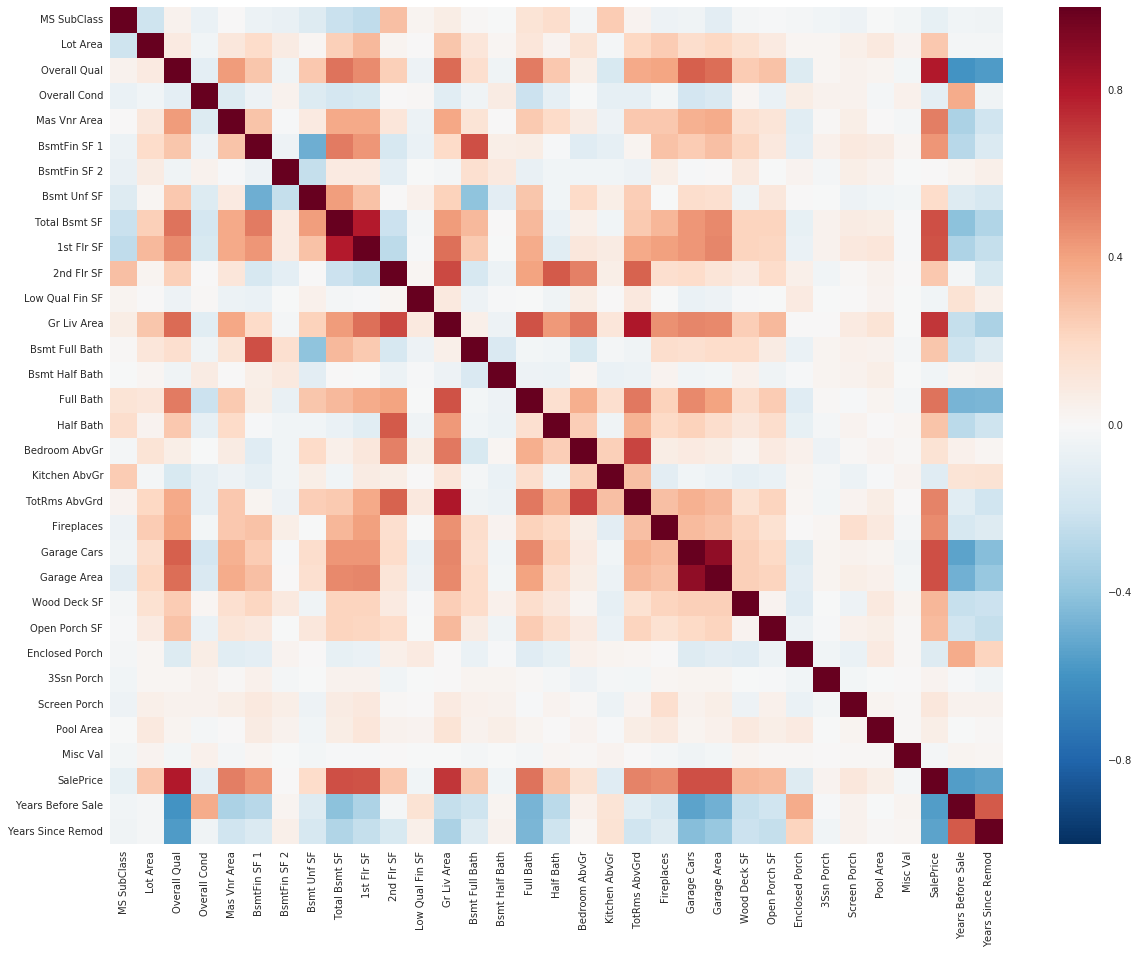

In [24]:
num_cols = transform_df.select_dtypes(include=['int', 'float'])
import seaborn as sns
%matplotlib inline  
corrmat = num_cols.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corrmat)

Features that correlate the most with our target column, SalePrice are:
* BsmtFin SF 1         
* Fireplaces           
* TotRms AbvGrd        
* Mas Vnr Area         
* Years Since Remod    
* Full Bath            
* Years Before Sale    
* 1st Flr SF           
* Garage Area          
* Total Bsmt SF        
* Garage Cars          
* Gr Liv Area          
* Overall Qual

In [25]:
corr_features = corrmat['SalePrice'].abs().sort_values()

In [26]:
# Let's only keep columns with a correlation coefficient of larger than 0.4 
transform_df = transform_df.drop(corr_features[corr_features < 0.4].index, axis=1)


Which categorical columns should we keep?

In [27]:
## Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [28]:
# Which categorical columns are still in a dataframe?
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)
transform_cat_cols    

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

In [29]:
# How many unique values in each categorical column?
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
uniqueness_counts

Street           2
Central Air      2
Land Contour     4
Lot Config       5
Bldg Type        5
Roof Style       6
Foundation       6
Heating          6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [30]:
# Aribtrary cutoff of 10 unique values
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(drop_nonuniq_cols, axis =1)

In [31]:
# Select just the remaining text columns and convert to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
# Create dummy columns and add back to the dataframe
transform_df = pd.concat([
    transform_df, 
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
],axis=1).drop(text_cols, axis=1)

Update select_features() and test_and_train()

In [36]:
def transform_features(df):
    #find all missing values in dataframe
    num_missing = df.isnull().sum()
    #remove columns with more than 5% of missing data
    drop_missing_cols = num_missing[(num_missing > len(df)/20)]                               
    df = df.drop(drop_missing_cols.index, axis=1)
                                     
    #find and count all text columns with empty values 
    text_cols = df.select_dtypes(include='object').isnull().sum()  
    #remove text cols with any missing values 
    drop_text_cols = text_cols[text_cols > 0]
    df = df.drop(drop_text_cols.index, axis=1)
                                     
    #find and count Numerical columns with missing values
    num_missing = df.select_dtypes(include=['int','float']).isnull().sum()
    #find columns where less than 5% of data is missing
    fixable_cols = num_missing[(num_missing < len(df)/20)&(num_missing>0)]
    #create a dictionary with the most common values in columns
    replacement_values_dict = df[fixable_cols.index].mode().to_dict(orient='records')[0]                                 
    #fill in with the most common value in that column  
    df = df.fillna(replacement_values_dict)   
                                     
    #new useful features creation 
    years_sold = df['Yr Sold'] - df['Year Built'] 
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add'] 
    #insert new features into a dataframe                                 
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod 
    df = df.drop([1702,2180,2181], axis=0) 
                                     
    # Drop columns that leak info about the final sale
    df = df.drop(['Order' ,'PID' ,'Mo Sold', 'Sale Condition', 'Sale Type','Year Built','Year Remod/Add'], axis=1)                                 
    return df

def select_features(df):
    #select only numerical columns
    numerical_df = df.select_dtypes(include=['int', 'float'])
    #find and choose the highest correlation coef. between target column and numerical columns
    abs_corr_coefs = numerical_df.corr()['SalePrice'].abs().sort_values()
    drop_corr_coefs = abs_corr_coefs[abs_corr_coefs < 0.4].index
    #drop remain cols 
    df = df.drop(drop_corr_coefs,axis=1)
    #now we will deal with nominal features
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    #find columns that still remain in df
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)
            
    #in order to change the type of the col to categorical we have to check the quantity of unique values in each col
    unique_count = df[transform_cat_cols].apply(lambda col: len(col.value_counts()))
    drop_nonunique = unique_count[unique_count > 10].index
    df = df.drop(drop_nonunique, axis = 1)

    # Select just the remaining text columns and convert to categorical
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols, axis=1)
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['int', 'float'])
    features = numeric_df.columns.drop('SalePrice')
    lr = linear_model.LinearRegression()
    
    if k==0:
        train = df.iloc[0:1460].copy()
        test = df.iloc[1460:].copy()

        lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        rmse = (mean_squared_error(test['SalePrice'], predictions))**(1/2)
        return rmse

    if k==1:
        #Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train['SalePrice'])
        predictions_one = lr.predict(test[features])
        rmse_one = (mean_squared_error(test['SalePrice'], predictions_one))**(1/2)
        
        lr.fit(test[features], test['SalePrice'])
        predictions_two = lr.predict(train[features])
        rmse_two = (mean_squared_error(train['SalePrice'], predictions_two))**(1/2)
        
        avg_rmse = np.mean([rmse_one,rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values=[]
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            
            lr.fit(train[features], train['SalePrice'])
            predictions = lr.predict(test[features])
            rmse = (mean_squared_error(test['SalePrice'], predictions))**(1/2)
            rmse_values.append(rmse)
            
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse
            
df = pd.read_csv('AmesHousing.tsv', delimiter='\t')    
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse    

[31622.53364873694, 38955.305098168814, 32190.420305722164, 29970.418027381813]


33184.66927000243